In [1]:
# 新增jupyter的话，需要拷贝下面的初始化设置
import sys
import os

if '/Users/zhang/PycharmProjects/strategy_engine_v2' not in sys.path:
    sys.path.append("/Users/zhang/PycharmProjects/strategy_engine_v2")
os.environ['config.dir'] = "/Users/zhang/PycharmProjects/strategy_engine_v2/interface"
os.environ['config.log'] = "/Users/zhang/PycharmProjects/strategy_engine_v2/interface/log_jupyter.yaml"
# 如果没有日志目录的话，则创建
if not os.path.exists("log"):
    os.makedirs("log")

In [2]:
# 策略的回报序列
import pandas as pd
import numpy as np
from se.domain2.account.account import *
from se.domain2.time_series.time_series import *
repo:AccountRepo = BeanContainer.getBean(AccountRepo)
account = repo.find_one("test60")
history_net_value_df = pd.Series(account.history_net_value)
pnls = [op.pnl for op in account.history_operations()]
pnls_p = [(op.pnl)/(op.start_cash) for op in account.history_operations()]
# 胜率
profits = np.array(pnls_p)[np.array(pnls_p) > 0]
loss =  np.array(pnls_p)[np.array(pnls_p) < 0]
p_rate = len(profits) / len(pnls_p)
l_rate = len(loss) / len(pnls_p)
# 平均盈利
p_mean = profits.mean()
l_mean = loss.mean()
print("profit_rate:{}, loss_rate:{}, profit_mean{}, loss_mean:{}".format(p_rate, l_rate, p_mean, l_mean))

(MainThread) 2021-02-18 15:27:11 INFO     __init__.py:27 初始化日志配置成功
(MainThread) 2021-02-18 15:27:11 INFO     __init__.py:41 初始化应用配置成功
(MainThread) 2021-02-18 15:27:11 WARNING  connection.py:101 Cluster.__init__ called with contact_points specified, but no load_balancing_policy. In the next major version, this will raise an error; please specify a load-balancing policy. (contact_points = ['127.0.0.1'], lbp = None)
(MainThread) 2021-02-18 15:27:11 INFO     policies.py:289 Using datacenter 'datacenter1' for DCAwareRoundRobinPolicy (via host '127.0.0.1:9042'); if incorrect, please specify a local_dc to the constructor, or limit contact points to local cluster nodes
profit_rate:0.14285714285714285, loss_rate:0.7142857142857143, profit_mean0.08879998588562012, loss_mean:-0.029114536263811108


In [3]:
pnls

[887.9998588562012,
 -22.79979705810547,
 -36.669734954833984,
 -136.80023193359375,
 -1084.7402458190918,
 -249.919677734375,
 0]

In [ ]:
import matplotlib.pyplot as plt
plt.hist(pnls_p, 20)


In [ ]:
# 基准的回报序列，取每天开盘到收盘的价格变化
start = pd.Timestamp("2020-01-01", tz='Asia/Shanghai')
end = pd.Timestamp("2020-12-01", tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, ['SPCE_STK_USD_SMART'])
ts = BeanContainer.getBean(TimeSeriesRepo).find_one("ibMinBar")
df = ts.history_data(command, from_local=True)
df = df.droplevel(level=1)
# 注意origin的tz必须跟原始的DataFrame的DatetimeIndex的timezone相同
df = df.resample('1D', origin=pd.Timestamp("2020-06-01 21:00:00", tz='Asia/Shanghai'))\
    .agg({'open': 'first', 'close': 'last'})
intra_day_rets = (df['close'] - df['open']) / df['open']
intra_day_rets = intra_day_rets.dropna()

rets = intra_day_rets.values
profit_rets = rets[rets > 0]
loss_rets = rets[rets < 0]
profit_rate = float(len(profit_rets)) / len(rets)
loss_rate = float(len(loss_rets)) / len(rets)
profit_mean = profit_rets.mean()
loss_mean = loss_rets.mean()

print("profit_rate:{}, loss_rate:{}, profit_mean{}, loss_mean:{}".format(profit_rate, loss_rate, profit_mean, loss_mean))


In [6]:
start = pd.Timestamp("2020-01-01", tz='Asia/Shanghai')
end = pd.Timestamp("2020-12-01", tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, ['SPCE_STK_USD_SMART'])
ts = BeanContainer.getBean(TimeSeriesRepo).find_one("ibMinBar")
df = ts.history_data(command, from_local=True)
df = df.droplevel(level=1)
# 注意origin的tz必须跟原始的DataFrame的DatetimeIndex的timezone相同
df = df.resample('1D', origin=pd.Timestamp("2020-01-01 21:00:00", tz='Asia/Shanghai'))\
    .agg({'open': 'first', 'close': 'last'}).dropna()
close_to_open_rets = (df['open'].shift(-1) - df['close']) / df['close']
close_to_close_rets = (df['close'].shift(-1) - df['close']) / df['close']
open_to_close_rets = (df['close'] - df['open']) / df['open']


<AxesSubplot:xlabel='visible_time'>

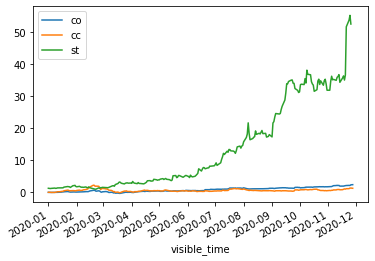

In [9]:
dd = pd.DataFrame({"co":(1+close_to_open_rets).cumprod() - 1, "cc":(1+close_to_close_rets).cumprod() - 1})
history_net_value_df = history_net_value_df.reindex(dd.index, method='bfill')
dd['st'] = (history_net_value_df-10000)/10000
dd.plot()


<AxesSubplot:xlabel='visible_time'>

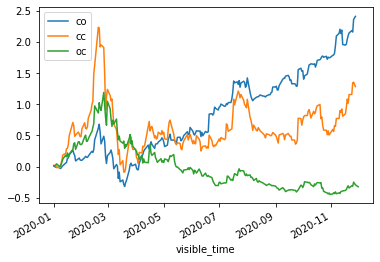

In [10]:
pd.DataFrame({"co":(1+close_to_open_rets).cumprod() - 1,
              "cc":(1+close_to_close_rets).cumprod() - 1,
              "oc":(1+open_to_close_rets).cumprod() -1
              }).plot()



In [11]:
# 下面考察日内回报、日间回报的相关性，考察方式为
# 1 使用前一个日内回报作为分类纬度,分类方式为等区间，以日间回报作为样本值，计算样本数、平均回报、方差
# 2 使用前一个日间回报作为分类纬度，分类方式为等区间，以日内回报作为样本值，计算样本数、平均回报、方差
data:DataFrame = pd.DataFrame({"co": close_to_open_rets,
              "oc": open_to_close_rets
              })
data = data.dropna()
bins=[-0.12, -0.1, -0.05, 0, 0.05, 0.1, 0.23]
data['oc_bins'] = pd.cut(data['oc'], bins)
co_grouped = data.groupby('oc_bins').co
co_grouped_result = pd.DataFrame({"co_mean": co_grouped.mean(),
                                  "co_count": co_grouped.count(),
                                  "co_std": co_grouped.std()})
co_grouped_result
# 从下面结果可以看出，当天的回报跟下一个日间回报成正相关


,co_mean,co_count,co_std
oc_bins,,,
"(-0.12, -0.1]",0.021845,3,0.047772
"(-0.1, -0.05]",-0.015342,29,0.073363
"(-0.05, 0.0]",-0.000441,95,0.037416
"(0.0, 0.05]",0.010752,68,0.039014
"(0.05, 0.1]",0.031203,28,0.052437
"(0.1, 0.23]",0.031408,6,0.063060


In [12]:
data = pd.DataFrame({"co": close_to_open_rets.shift(-1),
                    "oc": open_to_close_rets
                    })
data = data.dropna()

bins = [-0.20, -0.1, -0.05, 0, 0.05, 0.1, 0.21]
data['co_bins'] = pd.cut(data['co'], bins)
oc_grouped = data.groupby('co_bins').oc
oc_result = pd.DataFrame({"oc_mean": oc_grouped.mean(),
                                  "oc_count": oc_grouped.count(),
                                  "oc_std": oc_grouped.std()})
oc_result
# 下面结果表明当今天开盘相对与昨天收盘上涨时， 今天上涨的概率也比较高


,oc_mean,oc_count,oc_std
co_bins,,,
"(-0.2, -0.1]",-0.029545,5,0.078935
"(-0.1, -0.05]",-0.004529,13,0.066807
"(-0.05, 0.0]",-0.007642,69,0.043591
"(0.0, 0.05]",0.005777,115,0.052447
"(0.05, 0.1]",0.003844,19,0.049250
"(0.1, 0.21]",0.001993,9,0.076502


<AxesSubplot:xlabel='visible_time'>

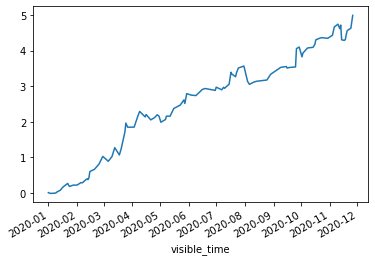

In [13]:
# 下面用open_to_close作为过滤条件，只有在当天的日内回报为正的情况下，才在收盘的时候买入，并且持有到下一个开盘

data:DataFrame = pd.DataFrame({"co": close_to_open_rets,
                            "oc": open_to_close_rets
                            })
filter_rets = data['co'][data['oc']>0]
((1+filter_rets).cumprod() - 1).plot()